In [1]:
import torch
from torch import nn
import torch.nn.functional as nnf
from transformers import (
    GPT2Tokenizer,
    GPT2LMHeadModel,
    AdamW,
    get_linear_schedule_with_warmup,
    CLIPModel,
    CLIPProcessor,
)
from typing import Tuple, List, Union, Optional
import os

In [2]:
class MLP(nn.Module):
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.model(x)

    def __init__(self, sizes: Tuple[int, ...], bias=True, act=nn.Tanh):
        super(MLP, self).__init__()
        layers = []
        for i in range(len(sizes) - 1):
            layers.append(nn.Linear(sizes[i], sizes[i + 1], bias=bias))
            if i < len(sizes) - 2:
                layers.append(act())
        self.model = nn.Sequential(*layers)

In [3]:
class ClipCaptionModel(nn.Module):
    def get_dummy_token(self, batch_size: int, device: torch.device) -> torch.Tensor:
        return torch.zeros(
            batch_size, self.prefix_length, dtype=torch.int64, device=device
        )

    def forward(
        self,
        tokens: torch.Tensor,
        prefix: torch.Tensor,
        mask: Optional[torch.Tensor] = None,
        labels: Optional[torch.Tensor] = None,
    ):
        embedding_text = self.gpt.transformer.wte(tokens)
        prefix_projections = self.clip_project(prefix).view(
            -1, self.prefix_length, self.gpt_embedding_size
        )
        embedding_cat = torch.cat((prefix_projections, embedding_text), dim=1)
        if labels is not None:
            dummy_token = self.get_dummy_token(tokens.shape[0], tokens.device)
            labels = torch.cat((dummy_token, tokens), dim=1)
        out = self.gpt(inputs_embeds=embedding_cat, labels=labels, attention_mask=mask)
        return out

    def __init__(
        self,
        prefix_length: int,
        prefix_size: int = 512,
    ):
        super(ClipCaptionModel, self).__init__()
        self.prefix_length = prefix_length
        self.gpt = GPT2LMHeadModel.from_pretrained("gpt2")
        self.gpt_embedding_size = self.gpt.transformer.wte.weight.shape[1]
        self.clip_project = MLP(
            (
                prefix_size,
                (self.gpt_embedding_size * prefix_length) // 2,
                self.gpt_embedding_size * prefix_length,
            )
        )

In [4]:
class ClipCaptionPrefix(ClipCaptionModel):
    def parameters(self, recurse: bool = True):
        return self.clip_project.parameters()

    def train(self, mode: bool = True):
        super(ClipCaptionPrefix, self).train(mode)
        self.gpt.eval()
        return self


In [5]:
def generate_beam(
    model,
    tokenizer,
    beam_size: int = 5,
    prompt=None,
    embed=None,
    entry_length=67,
    temperature=1.0,
    stop_token: str = ".",
):
    model.eval()
    stop_token_index = tokenizer.encode(stop_token)[0]
    tokens = None
    scores = None
    device = next(model.parameters()).device
    seq_lengths = torch.ones(beam_size, device=device)
    is_stopped = torch.zeros(beam_size, device=device, dtype=torch.bool)
    with torch.no_grad():
        if embed is not None:
            generated = embed
        else:
            if tokens is None:
                tokens = torch.tensor(tokenizer.encode(prompt))
                tokens = tokens.unsqueeze(0).to(device)
                generated = model.gpt.transformer.wte(tokens)
        for i in range(entry_length):
            outputs = model.gpt(inputs_embeds=generated)
            logits = outputs.logits
            logits = logits[:, -1, :] / (temperature if temperature > 0 else 1.0)
            logits = logits.softmax(-1).log()
            if scores is None:
                scores, next_tokens = logits.topk(beam_size, -1)
                generated = generated.expand(beam_size, *generated.shape[1:])
                next_tokens, scores = next_tokens.permute(1, 0), scores.squeeze(0)
                if tokens is None:
                    tokens = next_tokens
                else:
                    tokens = tokens.expand(beam_size, *tokens.shape[1:])
                    tokens = torch.cat((tokens, next_tokens), dim=1)
            else:
                logits[is_stopped] = -float(np.inf)
                logits[is_stopped, 0] = 0
                scores_sum = scores[:, None] + logits
                seq_lengths[~is_stopped] += 1
                scores_sum_average = scores_sum / seq_lengths[:, None]
                scores_sum_average, next_tokens = scores_sum_average.view(-1).topk(
                    beam_size, -1
                )
                next_tokens_source = next_tokens // scores_sum.shape[1]
                seq_lengths = seq_lengths[next_tokens_source]
                next_tokens = next_tokens % scores_sum.shape[1]
                next_tokens = next_tokens.unsqueeze(1)
                tokens = tokens[next_tokens_source]
                tokens = torch.cat((tokens, next_tokens), dim=1)
                generated = generated[next_tokens_source]
                scores = scores_sum_average * seq_lengths
                is_stopped = is_stopped[next_tokens_source]
            next_token_embed = model.gpt.transformer.wte(next_tokens.squeeze()).view(
                generated.shape[0], 1, -1
            )
            generated = torch.cat((generated, next_token_embed), dim=1)
            is_stopped = is_stopped + next_tokens.eq(stop_token_index).squeeze()
            if is_stopped.all():
                break
    scores = scores / seq_lengths
    output_list = tokens.cpu().numpy()
    output_texts = [
        tokenizer.decode(output[: int(length)])
        for output, length in zip(output_list, seq_lengths)
    ]
    order = scores.argsort(descending=True)
    output_texts = [output_texts[i] for i in order]
    return output_texts


In [6]:
def generate2(
    model,
    tokenizer,
    tokens=None,
    prompt=None,
    embed=None,
    entry_count=1,
    entry_length=67,  # maximum number of words
    top_p=0.8,
    temperature=1.0,
    stop_token: str = ".",
):
    model.eval()
    generated_num = 0
    generated_list = []
    stop_token_index = tokenizer.encode(stop_token)[0]
    filter_value = -float("Inf")
    device = next(model.parameters()).device

    with torch.no_grad():
        for entry_idx in range(entry_count):
            if embed is not None:
                generated = embed
            else:
                if tokens is None:
                    tokens = torch.tensor(tokenizer.encode(prompt))
                    tokens = tokens.unsqueeze(0).to(device)

                generated = model.gpt.transformer.wte(tokens)

            for i in range(entry_length):
                outputs = model.gpt(inputs_embeds=generated)
                logits = outputs.logits
                logits = logits[:, -1, :] / (temperature if temperature > 0 else 1.0)
                sorted_logits, sorted_indices = torch.sort(logits, descending=True)
                cumulative_probs = torch.cumsum(
                    nnf.softmax(sorted_logits, dim=-1), dim=-1
                )
                sorted_indices_to_remove = cumulative_probs > top_p
                sorted_indices_to_remove[..., 1:] = sorted_indices_to_remove[
                    ..., :-1
                ].clone()
                sorted_indices_to_remove[..., 0] = 0

                indices_to_remove = sorted_indices[sorted_indices_to_remove]
                logits[:, indices_to_remove] = filter_value
                next_token = torch.argmax(logits, -1).unsqueeze(0)
                next_token_embed = model.gpt.transformer.wte(next_token)
                if tokens is None:
                    tokens = next_token
                else:
                    tokens = torch.cat((tokens, next_token), dim=1)
                generated = torch.cat((generated, next_token_embed), dim=1)
                if stop_token_index == next_token.item():
                    break

            output_list = list(tokens.squeeze().cpu().numpy())
            output_text = tokenizer.decode(output_list)
            generated_list.append(output_text)

    return generated_list[0]


In [7]:
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
if torch.backends.mps.is_available():
    DEVICE = torch.device("mps")
    print("MPS available.")
else:
    print("MPS device not found.")

MPS available.


In [8]:
CLIP_VIT_16 = "openai/clip-vit-base-patch16"
CLIP_VIT_32 = "openai/clip-vit-base-patch32"
MODEL_NAME = CLIP_VIT_16

# Load CLIP model and processor from Hugging Face
clip_model = CLIPModel.from_pretrained(MODEL_NAME).to(DEVICE)
clip_processor = CLIPProcessor.from_pretrained(MODEL_NAME)
tokenizer = GPT2Tokenizer.from_pretrained("gpt2")

In [9]:
PREFIX_LENGTH = 10
WEIGHTS_PATH = "rsicd_prefix.pt"


def load_model():
    model = ClipCaptionPrefix(PREFIX_LENGTH)
    if os.path.isfile(WEIGHTS_PATH):
        print(f"loading model from {WEIGHTS_PATH}")
        model.load_state_dict(
            torch.load(WEIGHTS_PATH, map_location=torch.device("cpu"))
        )
    else:
        print(f"{WEIGHTS_PATH} is not exist")
    return model


model = load_model()
model = model.eval()
model = model.to(DEVICE)

loading model from rsicd_prefix.pt


/var/folders/my/qpyjqnl50l50rv_jcmx0phwh0000gn/T/ipykernel_2520/2228298088.py:10: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  torch.load(WEIGHTS_PATH, map_location=torch.d

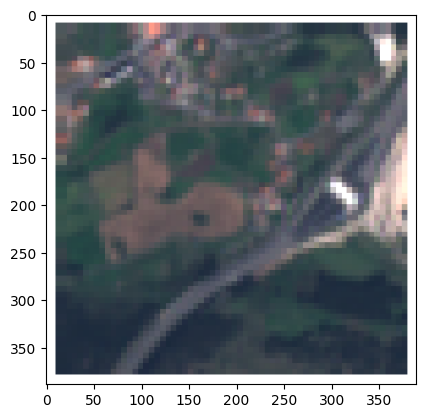

In [17]:
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt

path = "/Users/szymonlaszczynski/Documents/Projects/Studia/2024_winter/LLMs/uwr-modele-jezykowe-2024/project/img/remote_cats.jpg"
path = "/Users/szymonlaszczynski/Documents/Projects/Studia/2024_winter/LLMs/uwr-modele-jezykowe-2024/project/img/synchrocyclotron.jpg"
path = "/Users/szymonlaszczynski/Documents/Projects/Studia/2024_winter/LLMs/uwr-modele-jezykowe-2024/project/img/high-res-sat.png"
path = "/Users/szymonlaszczynski/Documents/Projects/Studia/2024_winter/LLMs/uwr-modele-jezykowe-2024/project/img/cemetary.png"
path = "/Users/szymonlaszczynski/Documents/Projects/Studia/2024_winter/LLMs/uwr-modele-jezykowe-2024/project/img/tree_in_a_field.png"
# path = "/Users/szymonlaszczynski/Documents/Projects/Studia/2024_winter/LLMs/uwr-modele-jezykowe-2024/project/img/europe.png"
# path = "/Users/szymonlaszczynski/Documents/Projects/Studia/2024_winter/LLMs/uwr-modele-jezykowe-2024/project/img/dam_on_river.png"
# path = "/Users/szymonlaszczynski/Documents/Projects/Studia/2024_winter/LLMs/uwr-modele-jezykowe-2024/project/img/satellite.png"
path = "/Users/szymonlaszczynski/Documents/Projects/Studia/2024_winter/LLMs/uwr-modele-jezykowe-2024/project/img/eurosat_2.png"

image = Image.open(path)

plt.imshow(image)

In [18]:
inputs = clip_processor(images=image, return_tensors="pt").to(DEVICE)
with torch.no_grad():
    prefix = clip_model.get_image_features(**inputs).to(DEVICE, dtype=torch.float32)
    prefix_embed = model.clip_project(prefix).reshape(1, PREFIX_LENGTH, -1)
    res = generate_beam(model, tokenizer, embed=prefix_embed)
    for i, r in enumerate(res):
        print(f"{i + 1}. {r}")
    print("")
    print(generate2(model, tokenizer, embed=prefix_embed))

# clip_image = clip_processor(images=image).unsqueeze(0).to(DEVICE)
# with torch.no_grad():
#     prefix = clip_model.encode_image(clip_image).to(DEVICE, dtype=torch.float32)
#     prefix_embed = model.clip_project(prefix).reshape(1, PREFIX_LENGTH, -1)
#     return generate_beam(model, tokenizer, embed=prefix_embed)[0]

1. Many green trees are in a piece of green meadow.
2. several green trees are near a piece of green meadow.
3. Many green trees are near a piece of green meadow.
4. Many green trees are planted on both sides of a piece of green meadow.
5. Many green trees are planted on the bare earth.

Many green trees are planted on both sides of a piece of green meadow.


In [18]:
def predict_caption(image: Image, use_beam_search: bool = False):
    image = clip_processor(image).unsqueeze(0).to(DEVICE)
    with torch.no_grad():
        prefix = clip_model.encode_image(image).to(DEVICE, dtype=torch.float32)
        prefix_embed = model.clip_project(prefix).reshape(1, PREFIX_LENGTH, -1)
    if use_beam_search:
        return generate_beam(model, tokenizer, embed=prefix_embed)[0]
    else:
        return generate2(model, tokenizer, embed=prefix_embed)

In [19]:
predict_caption(image)

ValueError: text input must be of type `str` (single example), `List[str]` (batch or single pretokenized example) or `List[List[str]]` (batch of pretokenized examples).

In [ ]:
# Prediction interface for Cog ⚙️
# Reference: https://github.com/replicate/cog/blob/main/docs/python.md

import clip
import os
import numpy as np
import torch.nn.functional as nnf
import sys
from transformers import (
    GPT2Tokenizer,
    GPT2LMHeadModel,
    AdamW,
    get_linear_schedule_with_warmup,
)
import skimage.io as io
import PIL.Image

import cog

# import torch

N = type(None)
V = np.array
ARRAY = np.ndarray
ARRAYS = Union[Tuple[ARRAY, ...], List[ARRAY]]
VS = Union[Tuple[V, ...], List[V]]
VN = Union[V, N]
VNS = Union[VS, N]
TS = Union[Tuple[T, ...], List[T]]
# TN = Optional[T]
TNS = Union[Tuple[TN, ...], List[TN]]
TSN = Optional[TS]
TA = Union[T, ARRAY]

WEIGHTS_PATHS = {
    "coco": "coco_weights.pt",
    "conceptual-captions": "conceptual_weights.pt",
}

# D = torch.device


class Predictor(cog.Predictor):
    def setup(self):
        """Load the model into memory to make running multiple predictions efficient"""
        self.device = torch.device("cuda")
        self.clip_model, self.preprocess = clip.load(
            "ViT-B/32", device=self.device, jit=False
        )
        self.tokenizer = GPT2Tokenizer.from_pretrained("gpt2")

        self.models = {}
        self.prefix_length = 10
        for key, weights_path in WEIGHTS_PATHS.items():
            model = ClipCaptionModel(self.prefix_length)
            model.load_state_dict(torch.load(weights_path, map_location=CPU))
            model = model.eval()
            model = model.to(self.device)
            self.models[key] = model

    @cog.input("image", type=cog.Path, help="Input image")
    @cog.input(
        "model",
        type=str,
        options=WEIGHTS_PATHS.keys(),
        default="coco",
        help="Model to use",
    )
    @cog.input(
        "use_beam_search",
        type=bool,
        default=False,
        help="Whether to apply beam search to generate the output text",
    )
    def predict(self, image, model, use_beam_search):
        """Run a single prediction on the model"""
        image = io.imread(image)
        model = self.models[model]
        pil_image = PIL.Image.fromarray(image)
        image = self.preprocess(pil_image).unsqueeze(0).to(self.device)
        with torch.no_grad():
            prefix = self.clip_model.encode_image(image).to(
                self.device, dtype=torch.float32
            )
            prefix_embed = model.clip_project(prefix).reshape(1, self.prefix_length, -1)
        if use_beam_search:
            return generate_beam(model, self.tokenizer, embed=prefix_embed)[0]
        else:
            return generate2(model, self.tokenizer, embed=prefix_embed)
